Data Source
-----------
Forex EURUSD from Jan 2011 to Dec 2018 (8 years) downloaded from QuanDL

In [1]:
# !pip install mkl
# !pip install --upgrade keras
import pandas as pd

# Data source - fetch dataframe for Forex EURUSD from Jan 2011 to Dec 2018 (8 years)
df = pd.read_csv('EURUSD_DAY_2011_2018.csv')
df.columns = ('Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume')
print (df.head())
print (df.shape)

         Date   Time     Open     High      Low    Close  Volume
0  2011.01.03  00:00  1.33560  1.33947  1.32500  1.33551  164193
1  2011.01.04  00:00  1.33566  1.34298  1.32923  1.33179  215600
2  2011.01.05  00:00  1.33181  1.33248  1.31262  1.31556  204024
3  2011.01.06  00:00  1.31556  1.31698  1.29723  1.29787  185391
4  2011.01.07  00:00  1.29787  1.30209  1.29045  1.29060  180709
(2501, 7)


Data Cleaning
-----------

In [2]:
# Drop unused columns/features/dimensions
df.drop(columns=['Time', 'Open', 'High', 'Low', 'Volume'], inplace=True)
print(df.head())
print(df.shape)

         Date    Close
0  2011.01.03  1.33551
1  2011.01.04  1.33179
2  2011.01.05  1.31556
3  2011.01.06  1.29787
4  2011.01.07  1.29060
(2501, 2)


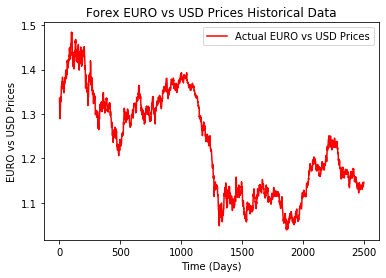

In [4]:
import matplotlib.pyplot as plt
df_plot = df.iloc[:,1:2].values.astype(float)
# Visualising the Data
plt.plot(df_plot, color = 'red', label = 'Actual EURO vs USD Prices')
plt.title('Forex EURO vs USD Prices Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('EURO vs USD Prices')
plt.legend()
plt.show()

Modeling 
--------
LSTM Stateful using Keras / TensorFlow backend

In [5]:
#import packages
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import load_model

Using TensorFlow backend.
c:\program files\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\program files\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\program files\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\program files\python37\lib\site-packages\tensorflow\python\framework\dtype

LSTM parameters
---------------
Batch size: 64 records
Epochs: 120 loops
Timesteps: 30 days

In [6]:
# defining the batch size and number of epochs
batch_size = 64
epochs = 120
# 30 steps to the left or we are looking at sliding windows of 10 days in the past to predict
timesteps = 30 
print("Batch size: ", batch_size)
print("Epochs: ", epochs)
print("Timesteps (sliding windows): ", timesteps)

Batch size:  64
Epochs:  120
Timesteps (sliding windows):  30


Trainings-set size
------------------
With **stateful LSTMs** the trainings-set size must be divisible without remainder by the batch-size (modulo = 0)

In [7]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))

In [8]:
print("Dataframe Length: ", len(df))
length = get_train_length(df, batch_size, 0.1)
print("Train length related to batch size: ", length)

Dataframe Length:  2501
2176
2240
Train length related to batch size:  2240


In [9]:
# Pre-processing - Construct our Input and Output Data Construction for LSTM
# First, increase the upper boundary of traning set size by mulipling by two
# Adding timesteps * 2
upper_train = length + timesteps*2
df_data_1_train = df[0:upper_train]
training_set = df_data_1_train.iloc[:,1:2].values
print('Training Set: ', training_set)
print('Training Shape: ', training_set.shape)

Training Set:  [[1.33551]
 [1.33179]
 [1.31556]
 ...
 [1.18671]
 [1.18467]
 [1.19137]]
Training Shape:  (2300, 1)


In [10]:
# Feature Scaling
# scale between 0 and 1. the weights are esier to find.
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(2300, 1)

In [11]:
# Input data - X_train (timesteps = 10)
X_train = []
# Ouput data - y_train - predicted future values
y_train = []

# Creating a data structure with n timesteps
print("Length + timesteps: ", length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print("Length of X_train", len(X_train))
print("Lenght of y_train", len(y_train))

# create X_train matrix
# 30 items per array (timestep) 
print("X_train 3D Matrix: ", X_train[0:2])
print("X_train array shape: ", np.array(X_train).shape)

#create Y_train matrix
#30 items per array (timestep) 
print("y_train 3D Matrix: ", y_train[0:2])
print("y_train array shape: ", np.array(y_train).shape)

Length + timesteps:  2270
Length of X_train 2240
Lenght of y_train 2240
X_train 3D Matrix:  [array([0.66623966, 0.65787936, 0.62140417, 0.58164779, 0.56530924,
       0.56261237, 0.5782767 , 0.58209727, 0.61477436, 0.66522834,
       0.6733639 , 0.67147609, 0.64956401, 0.6712963 , 0.68790453,
       0.69093851, 0.725863  , 0.72548094, 0.73078479, 0.74029126,
       0.74593222, 0.74860662, 0.72350324, 0.71487325, 0.74678623,
       0.77256383, 0.76975458, 0.72649227, 0.71673858, 0.71514293]), array([0.65787936, 0.62140417, 0.58164779, 0.56530924, 0.56261237,
       0.5782767 , 0.58209727, 0.61477436, 0.66522834, 0.6733639 ,
       0.67147609, 0.64956401, 0.6712963 , 0.68790453, 0.69093851,
       0.725863  , 0.72548094, 0.73078479, 0.74029126, 0.74593222,
       0.74860662, 0.72350324, 0.71487325, 0.74678623, 0.77256383,
       0.76975458, 0.72649227, 0.71673858, 0.71514293, 0.71952535])]
X_train array shape:  (2240, 30)
y_train 3D Matrix:  [array([0.71952535, 0.72687433, 0.74799982, 0.

In [12]:
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)


X_train shape:  (2240, 30, 1)
y_train shape:  (2240, 30, 1)


Building the LSTM using Keras Functional API
--------------------------------------------

In [13]:
########## Building the LSTM
# Importing the Keras libraries and packages

from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py

In [14]:
########## Anatomy of a LSTM Node
# Initialising the LSTM Model with MAE Loss-Function
# Keras has 2 API: Sequential API and Functional API
# Here, we use Functional API

# Input layer:
inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))

# Each layer is the input of the next layer
# mae -> mean absolute error loss function
# We use 10 nodes
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

# Output layer
output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

# Optimizer - adam is fast starting off and then gets slower and more precise
regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

W0828 19:25:09.187156 10172 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 19:25:09.198115 10172 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 19:25:09.200099 10172 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 19:25:09.461780 10172 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_1 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_2 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_1 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


LSTM Param Number
-----------------
1. LSTM Cell has <bold>3 Gates</bold>: 
    - input (what to let in), 
    - forget (what to forget) and 
    - output (what to write to the output)
2. LSTM **Cell State** is its **memory**
3. LSTM Hidden State is equivalent to the Cell output:
    - lstm_hidden_state_size (number of neurons = memory cells) = lstm_outputs_size
4. Parameters:
    - weights for the inputs (lstm_inputs_size)
    - weights for the outputs (lstm_outputs_size)
    - bias variable
5.  Result from previous point - for all 3 Gates and for Cell State ( = 4)  
   \begin{equation}
          \textbf{PARAMETERS} = \textbf4 \times \textbf{ LSTM outputs size} \times (\textbf{weights LSTM inputs size} + \textbf{weights LSTM outputs size} + 1 \textbf{ bias variable})
    \end{equation}
    



In [15]:
######### Number of Parameters
# 1. Decide how to handle the memory for each of 3 LSTM Cell Gates (input, forget, output)
# 2. LSTM Cell State is its memory
# 3. LSTM Hidden State is equivalent to the Cell ouput
# 4. Parameters:
#       - Weights for the inputs (lstm_inputs_size)
#       - Weights for the outputs (lstm_outputs_size)
#       - bias variable
# 5. Result from previous point for all 3 Gates and for Cell State (= 4)
#
#       PARAMETERS = 4 X LSTM outputs size x (weights LSTM input size + weights LSTM outputs size + 1 bias variable)
#
# 1st LSTM Layer
#   parameters = 4 * 10 * (1 + 10 + 1)
# print(parameters)
# 
# 2nd LSTM Layer
#   parameters = 4 * 10 * (10 + 10 + 1)
#   print(parameters)

Running modeling with MAE (Mean Absolute Error)
---

In [16]:
########## Model Training with Statefull
# Fitting the training set

#Statefull
for i in range(epochs):
    print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    #resets only the states but the weights, cell and hidden are kept.
    regressor_mae.reset_states()
    
#Stateless
#between the batches the cell and hidden states are lost.
#regressor_mae.fit(X_train, y_train, shuffle=False, epochs = epochs, batch_size = batch_size)

W0828 19:25:12.131716 10172 deprecation.py:323] From c:\program files\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 0


W0828 19:25:12.530649 10172 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0828 19:25:12.594479 10172 deprecation_wrapper.py:119] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/1
2240/2240 [==============================] - 1s 382us/step - loss: 0.3060
Epoch: 1
Epoch 1/1
2240/2240 [==============================] - 0s 136us/step - loss: 0.1432
Epoch: 2
Epoch 1/1
2240/2240 [==============================] - 0s 138us/step - loss: 0.1508
Epoch: 3
Epoch 1/1
2240/2240 [==============================] - 0s 141us/step - loss: 0.0905
Epoch: 4
Epoch 1/1
2240/2240 [==============================] - 0s 142us/step - loss: 0.0809
Epoch: 5
Epoch 1/1
2240/2240 [==============================] - 0s 143us/step - loss: 0.0834
Epoch: 6
Epoch 1/1
2240/2240 [==============================] - 0s 143us/step - loss: 0.0882
Epoch: 7
Epoch 1/1
2240/2240 [==============================] - 0s 138us/step - loss: 0.0829
Epoch: 8
Epoch 1/1
2240/2240 [==============================] - 0s 139us/step - loss: 0.0813
Epoch: 9
Epoch 1/1
2240/2240 [==============================] - 0s 140us/step - loss: 0.0805
Epoch: 10
Epoch 1/1
2240/2240 [==============================] - 0s 143us/step 

In [17]:
#save model
import h5py
regressor_mae.save(filepath="my_model_with_mae_30_ts.h5")

In [18]:
#load model
import h5py
regressor_mae = load_model("my_model_with_mae_30_ts.h5")

In [19]:
def get_test_length(dataset, batch_size):
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))

In [20]:
test_length = get_test_length(df, batch_size)
print("Test Length: ", test_length)

upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print("Testset Length: ", testset_length)   
print("Upper Train, Upper Test, Length: ", upper_train, upper_test, len(df))

2364
2428
Test Length:  2428
Testset Length:  128
Upper Train, Upper Test, Length:  2300 2488 2501


In [21]:
########## construct test set

#subsetting
df_test = df[upper_train:upper_test] 
test_set = df_test.iloc[:,1:2].values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [22]:
print("X_test.shape: ", X_test.shape)

X_test.shape:  (128, 30, 1)


In [23]:
# prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print(predicted_bcg_values_test_mae.shape)

# reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print(predicted_bcg_values_test_mae.shape)

# inverse transform for forecasting
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)

# creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)

(128, 30, 1)
(128, 30)
(98, 1)


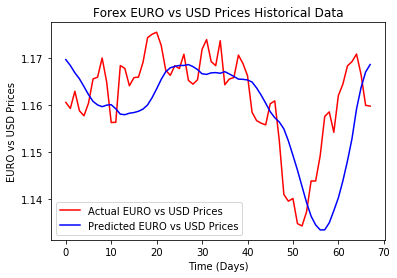

In [24]:
# Visualising the results
plt.plot(test_set[timesteps:len(y_test)].astype(float), color = 'red', label = 'Actual EURO vs USD Prices')
plt.plot(y_test[0:len(y_test) - timesteps].astype(float), color = 'blue', label = 'Predicted EURO vs USD Prices')
plt.title('Forex EURO vs USD Prices Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('EURO vs USD Prices')
plt.legend()
plt.show()

In [25]:
#MSE (mean sqared error)
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(r"RMSE (Root Mean Square Error):", rmse)

RMSE (Root Mean Square Error): 0.009613904012023765


In [26]:
#MAE (mean absolut error)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(r"MAE (Mean Absolute Error)", mae)

MAE (Mean Absolute Error) 0.007628275272705977


In [27]:
# Initialising the LSTM Model with MSE Loss Function

inputs_1_mse = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mse = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mse)
lstm_2_mse = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mse)

output_1_mse = Dense(units = 1)(lstm_2_mse)

regressor_mse = Model(inputs=inputs_1_mse, outputs = output_1_mse)

#mse -> mean squared error as loss function
regressor_mse.compile(optimizer='adam', loss = 'mse')
regressor_mse.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (64, 30, 1)               0         
_________________________________________________________________
lstm_3 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_4 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_2 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


Running modeling with MSE (Mean Square Error)
---

In [28]:
epochs = 120
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mse.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mse.reset_states()

Epoch: 0
Epoch 1/1
2240/2240 [==============================] - 1s 458us/step - loss: 0.2058
Epoch: 1
Epoch 1/1
2240/2240 [==============================] - 0s 138us/step - loss: 0.0377
Epoch: 2
Epoch 1/1
2240/2240 [==============================] - 0s 135us/step - loss: 0.0227
Epoch: 3
Epoch 1/1
2240/2240 [==============================] - 0s 139us/step - loss: 0.0166
Epoch: 4
Epoch 1/1
2240/2240 [==============================] - 0s 138us/step - loss: 0.0150
Epoch: 5
Epoch 1/1
2240/2240 [==============================] - 0s 137us/step - loss: 0.0142
Epoch: 6
Epoch 1/1
2240/2240 [==============================] - 0s 137us/step - loss: 0.0139
Epoch: 7
Epoch 1/1
2240/2240 [==============================] - 0s 144us/step - loss: 0.0136
Epoch: 8
Epoch 1/1
2240/2240 [==============================] - 0s 138us/step - loss: 0.0133
Epoch: 9
Epoch 1/1
2240/2240 [==============================] - 0s 139us/step - loss: 0.0131
Epoch: 10
Epoch 1/1
2240/2240 [==============================] - 0s 14

In [29]:
import h5py
regressor_mse.save(filepath="my_model_with_mse_30_ts.h5")

In [30]:
regressor_mse = load_model("my_model_with_mse_30_ts.h5")

In [31]:
predicted_bcg_values_test_mse = regressor_mse.predict(X_test, batch_size=batch_size)
regressor_mse.reset_states()

predicted_bcg_values_test_mse = np.reshape(predicted_bcg_values_test_mse, 
                                       (predicted_bcg_values_test_mse.shape[0], 
                                        predicted_bcg_values_test_mse.shape[1]))
predicted_bcg_values_test_mse = sc.inverse_transform(predicted_bcg_values_test_mse)

pred_mse = []

for j in range(0, testset_length - timesteps):
    pred_mse = np.append(pred_mse, predicted_bcg_values_test_mse[j, timesteps-1])

pred_mse = np.reshape(pred_mse, (pred_mse.shape[0], 1))

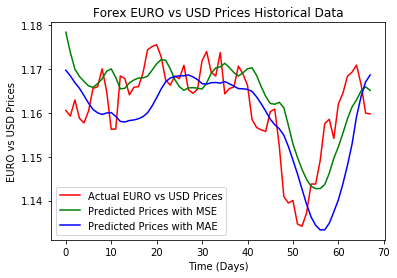

In [32]:
# Visualising the results
plt.plot(test_set[timesteps:len(pred_mse)].astype(float), color = 'red', label = 'Actual EURO vs USD Prices')
plt.plot(pred_mse[0:len(pred_mse) - timesteps], color = 'green', label = 'Predicted Prices with MSE')
plt.plot(y_test[0:len(y_test) - timesteps], color = 'blue', label = 'Predicted Prices with MAE')
plt.title('Forex EURO vs USD Prices Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('EURO vs USD Prices')
plt.legend()
plt.show()


In [33]:
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps]))
print(r"Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): 0.007972743413873322


In [34]:
mean = np.mean(np.float64(test_set[timesteps:len(pred_mse)]))
print(r"Mean: ", mean)

Mean:  1.1616183823529411


In [35]:
rmse/mean * 100

0.6863479034933968

In [36]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps])
print(r"MAE (Mean Absolute Error)", mae)

MAE (Mean Absolute Error) 0.006224155090556425


In [37]:
mae/mean * 100

0.5358175443082223